In [266]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split

## Load the Dataset

In [267]:
df = pd.read_csv("../data/Titanic.csv")
df.head()

,Row Number,Passenger Class,Name,Gender,Age,No of Siblings,No of Parents,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Life Boat,Survived
0,1,First,"Allen, Miss. Elisabeth Walton",Female,29,0,0,24160,211.3375,B5,Southampton,2,Yes
1,2,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.55,C22 C26,Southampton,11,Yes
2,3,First,"Allison, Miss. Helen Loraine",Female,2,1,2,113781,151.55,C22 C26,Southampton,?,No
3,4,First,"Allison, Mr. Hudson Joshua Creighton",Male,30,1,2,113781,151.55,C22 C26,Southampton,?,No
4,5,First,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25,1,2,113781,151.55,C22 C26,Southampton,?,No


## Rename Features

In [268]:
# Rename some of the features to make data cleaning and further analysis easier
df.rename(columns={'Port of Embarkation': 'Port', 'Passenger Class': 'Class', 'Passenger Fare': 'Fare', 'Cabin ': 'Cabin'}, inplace=True)

## Simple Data Inspection

In [269]:
df.shape

(1309, 13)

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Row Number      1309 non-null   int64 
 1   Class           1309 non-null   object
 2   Name            1309 non-null   object
 3   Gender          1309 non-null   object
 4   Age             1309 non-null   object
 5   No of Siblings  1309 non-null   int64 
 6   No of Parents   1309 non-null   int64 
 7   Ticket Number   1309 non-null   object
 8   Fare            1309 non-null   object
 9   Cabin           1309 non-null   object
 10  Port            1309 non-null   object
 11  Life Boat       1309 non-null   object
 12  Survived        1309 non-null   object
dtypes: int64(3), object(10)
memory usage: 133.1+ KB


In [271]:
df.describe(include='all')

,Row Number,Class,Name,Gender,Age,No of Siblings,No of Parents,Ticket Number,Fare,Cabin,Port,Life Boat,Survived
count,1309.000000,1309,1309,1309,1309,1309.000000,1309.000000,1309,1309,1309,1309,1309,1309
unique,NaN,3,1307,2,99,NaN,NaN,929,282,187,4,28,2
top,NaN,Third,"Connolly, Miss. Kate",Male,?,NaN,NaN,CA. 2343,8.05,?,Southampton,?,No
freq,NaN,709,2,843,263,NaN,NaN,11,60,1014,914,823,809
mean,655.000000,NaN,NaN,NaN,NaN,0.498854,0.385027,NaN,NaN,NaN,NaN,NaN,NaN
std,378.020061,NaN,NaN,NaN,NaN,1.041658,0.865560,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,328.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,655.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,982.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Note the issues with the data :

- Age is of type object
- Age, Cabin, Life Boat all show the most frequently occurring value to be '?' - Inspect the other features to determine if '?' is used in place of NaN and replace all.

## Convert Age to Numeric

In [272]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

In [273]:
df['Age'] = df['Age'].round(0)

## Loop through the categorical features and inspect the possible values

In [274]:
cat_feats = ['Class', 'Name', 'Gender', 'Ticket Number',
       'Cabin', 'Port', 'Life Boat', 'Survived']

In [275]:
for feat in cat_feats:
    print(f"********* Feature: {feat} *********\n")
    print(f"{df[feat].unique()}\n")

********* Feature: Class *********

['First' 'Second' 'Third']

********* Feature: Name *********

['Allen, Miss. Elisabeth Walton' 'Allison, Master. Hudson Trevor'
 'Allison, Miss. Helen Loraine' ... 'Zakarian, Mr. Mapriededer'
 'Zakarian, Mr. Ortin' 'Zimmerman, Mr. Leo']

********* Feature: Gender *********

['Female' 'Male']

********* Feature: Ticket Number *********

['24160' '113781' '19952' '13502' '112050' '11769' 'PC 17609' 'PC 17757'
 'PC 17477' '19877' '27042' 'PC 17318' 'PC 17558' '11813' '13050' '11751'
 '111369' 'PC 17483' '13905' '11967' 'PC 17760' '110564' '113784' '112277'
 '36928' '113783' '110489' 'PC 17608' '113505' '111427' '113054'
 'PC 17591' '112379' 'PC 17610' '16966' '113050' '113798' 'PC 17476'
 'PC 17606' 'PC 17755' '695' '113059' '113760' '19924' '17770'
 'W.E.P. 5734' '113806' '110152' 'PC 17594' '112051' '13508' '110465'
 '5727' 'PC 17756' '11770' '113791' 'WE/P 5735' '112901' 'PC 17599'
 '113055' '113804' 'F.C. 12750' '17474' '33638' 'PC 17761' '11755'
 

## Replace "?" with NAs

In [276]:
df[df['Port'] == '?']

,Row Number,Class,Name,Gender,Age,No of Siblings,No of Parents,Ticket Number,Fare,Cabin,Port,Life Boat,Survived
168,169,First,"Icard, Miss. Amelie",Female,38.0,0,0,113572,80,B28,?,6,Yes
284,285,First,"Stone, Mrs. George Nelson (Martha Evelyn)",Female,62.0,0,0,113572,80,B28,?,6,Yes


In [277]:
df.replace('?', np.nan, inplace=True)

## Identify Missing Values

In [278]:
df.dtypes

Row Number          int64
Class              object
Name               object
Gender             object
Age               float64
No of Siblings      int64
No of Parents       int64
Ticket Number      object
Fare               object
Cabin              object
Port               object
Life Boat          object
Survived           object
dtype: object

In [279]:
df.isna().sum()

Row Number           0
Class                0
Name                 0
Gender               0
Age                263
No of Siblings       0
No of Parents        0
Ticket Number        0
Fare                 1
Cabin             1014
Port                 2
Life Boat          823
Survived             0
dtype: int64

In [280]:
df = df[~((df['Fare'].isna()) | (df['Port'].isna()))]

In [281]:
df.columns

Index(['Row Number', 'Class', 'Name', 'Gender', 'Age', 'No of Siblings',
       'No of Parents', 'Ticket Number', 'Fare', 'Cabin', 'Port', 'Life Boat',
       'Survived'],
      dtype='object')

In [282]:
df.drop(columns=['Cabin', 'Life Boat', 'Row Number'], inplace=True)

In [283]:
df.isna().sum()

Class               0
Name                0
Gender              0
Age               263
No of Siblings      0
No of Parents       0
Ticket Number       0
Fare                0
Port                0
Survived            0
dtype: int64

In [284]:
df.loc[df['Age'].isna()]

,Class,Name,Gender,Age,No of Siblings,No of Parents,Ticket Number,Fare,Port,Survived
15,First,"Baumann, Mr. John D",Male,NaN,0,0,PC 17318,25.925,Southampton,No
37,First,"Bradley, Mr. George (""George Arthur Brayton"")",Male,NaN,0,0,111427,26.55,Southampton,Yes
40,First,"Brewe, Dr. Arthur Jackson",Male,NaN,0,0,112379,39.6,Cherbourg,No
46,First,"Cairns, Mr. Alexander",Male,NaN,0,0,113798,31,Southampton,No
59,First,"Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genev...",Female,NaN,0,0,17770,27.7208,Cherbourg,Yes
...,...,...,...,...,...,...,...,...,...,...
1293,Third,"Williams, Mr. Howard Hugh ""Harry""",Male,NaN,0,0,A/5 2466,8.05,Southampton,No
1297,Third,"Wiseman, Mr. Phillippe",Male,NaN,0,0,A/4. 34244,7.25,Southampton,No
1302,Third,"Yousif, Mr. Wazli",Male,NaN,0,0,2647,7.225,Cherbourg,No
1303,Third,"Yousseff, Mr. Gerious",Male,NaN,0,0,2627,14.4583,Cherbourg,No


In [285]:
df.groupby(['Gender', 'Class'])['Age'].mean()

Gender  Class 
Female  First     36.839695
        Second    27.495146
        Third     22.177632
Male    First     41.026490
        Second    30.810127
        Third     25.841954
Name: Age, dtype: float64

## Impute Age using average age by gender, class, No of Siblings

In [286]:
df['Age'] = df.groupby(['Gender', 'Class'])['Age'].transform(lambda x: round(x.fillna(x.mean())))

In [287]:
df.isna().sum()

Class             0
Name              0
Gender            0
Age               0
No of Siblings    0
No of Parents     0
Ticket Number     0
Fare              0
Port              0
Survived          0
dtype: int64

## Exploratory Data Analysis

**Start by exploring Survived**

- **Class Imbalance:** We want to analyse the balance of classes. Imbalanced classes occur in classification problems when the number of observations of one class occurs significantly more than the other class(es). 
- **Chi Square Goodness of Fit:** Additionally, we would like to confirm that the differences between observed survival rates and expected survival rates are statistically significant and cannot be attributed to randomness.

### Class Imbalance 

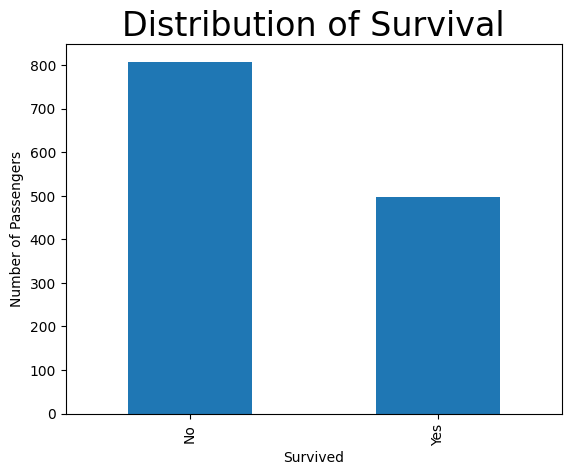

In [288]:
df['Survived'].value_counts().plot(kind='bar')

plt.title("Distribution of Survival", fontsize=24)
plt.ylabel("Number of Passengers")
plt.show()

In [289]:
survived = df['Survived'].value_counts()
survived_yes = survived.iloc[1]
survived_no = survived.iloc[0]


print(f'Number of passengers who survived: {survived_yes}')
print(f'Number of passengers who did not survive: {survived_no}')

Number of passengers who survived: 498
Number of passengers who did not survive: 808


In [290]:
class_balance_ratio = round(float(survived_no/survived_yes),2)
class_balance_ratio

1.62

In [291]:
print(f"Percent of Passengers who survived: {round(len(df[df['Survived']=='Yes']) / len(df)* 100,2)}%")

Percent of Passengers who survived: 38.13%


### Chi Square Goodness of Fit

In [292]:
observed = [float(survived_yes), float(survived_no)]
expected = [float(df['Survived'].count()/2), float(df['Survived'].count()/2)]
print(f"Expected: {expected}\nObserved: {observed}")

Expected: [653.0, 653.0]
Observed: [498.0, 808.0]


In [295]:
from scipy.stats import chisquare
chi2, p_value = chisquare(f_obs=observed, f_exp=expected)

In [296]:
print(f"Chi squared: {chi2}\n")
print(f"P value: {p_value}")

Chi squared: 73.58346094946401

P value: 9.64696289566531e-18


### **Chi Square Summary**

The Chi Square Goodness was conducted and compared to the expected survival accounts under an assumption of a 50% probability of survival. 

**Results:**

The results showed a statistically significant difference, with a chi sqaure statistic of 73.58 and a p value < 0.0001, and 1 degree of freedom.

## Univariate Analysis

**Age:**
- Central Tendency
- Measure of Spread
- Shape
- Outlier Detection
- Recommendations

In [300]:
df['Age'].describe()

count    1306.000000
mean       29.307810
std        13.125106
min         0.000000
25%        22.000000
50%        26.000000
75%        36.000000
max        80.000000
Name: Age, dtype: float64

In [313]:
print(f"Median: {float(df['Age'].median())}")
print(f"Mode: {float(df['Age'].mode().iloc[0])}")

Median: 26.0
Mode: 26.0


In [317]:
age_skew = df['Age'].skew()
age_kurt = df['Age'].kurt()

print(F"Skewness: {round(float(age_skew),2)}")
print(F"Kurtosis: {round(float(age_kurt),2)}")


Skewness: 0.54
Kurtosis: 0.71


In [320]:
df['Age'].isna().sum()

np.int64(0)

In [ ]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(x=df["Age"], bins=30, edgecolor='black', color='skyblue', density=True)

kde = gaussian_kde(df['Age'])
x_vals = np.linspace(min(df['Age']), max(df['Age']), 1000)
ax.plot(x_vals, kde(x_vals), color = 'red', linestyle = '--', labe='KDE')

plt.show()